In [1]:
# Download Yellow Taxi Trip Records" for January and February 2022.
!wget -nc -O ./data/yellow_jan.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-01.parquet
!wget -nc -O ./data/yellow_feb.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2022-02.parquet
!wget -nc -O ./data/green_jan.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet
!wget -nc -O ./data/green_feb.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet
!wget -nc -O ./data/green_mar.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet

File ‘./data/yellow_jan.parquet’ already there; not retrieving.
File ‘./data/yellow_feb.parquet’ already there; not retrieving.
File ‘./data/green_jan.parquet’ already there; not retrieving.
File ‘./data/green_feb.parquet’ already there; not retrieving.
File ‘./data/green_mar.parquet’ already there; not retrieving.


# Setup

In [34]:
import pickle
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import mlflow

# Where does the artifact being saved?
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# What experiment are we going to run
mlflow.set_experiment("nyc-taxi")

2023/06/07 01:46:16 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/07 01:46:16 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2023/06/07 01:46:16 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/ubuntu/taxi_mlops/mlruns/1', creation_time=1686102376338, experiment_id='1', last_update_time=1686102376338, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [4]:
df = pd.read_parquet("./data/green_jan.parquet")
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,0.50,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,0.50,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,3.25,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,0.50,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,0.50,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75


In [5]:
df.shape

(62495, 20)

## Compute duration

In [7]:
# Duration in minutes
df["duration"] = (
    df.lpep_dropoff_datetime - df.lpep_pickup_datetime
).dt.total_seconds() / 60.0
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2022-01-01 00:14:21,2022-01-01 00:15:33,N,1.0,42,42,1.0,0.44,3.5,...,0.5,0.00,0.0,None,0.3,4.80,2.0,1.0,0.00,1.200000
1,1,2022-01-01 00:20:55,2022-01-01 00:29:38,N,1.0,116,41,1.0,2.10,9.5,...,0.5,0.00,0.0,None,0.3,10.80,2.0,1.0,0.00,8.716667
2,1,2022-01-01 00:57:02,2022-01-01 01:13:14,N,1.0,41,140,1.0,3.70,14.5,...,0.5,4.60,0.0,None,0.3,23.15,1.0,1.0,2.75,16.200000
3,2,2022-01-01 00:07:42,2022-01-01 00:15:57,N,1.0,181,181,1.0,1.69,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,8.250000
4,2,2022-01-01 00:07:50,2022-01-01 00:28:52,N,1.0,33,170,1.0,6.26,22.0,...,0.5,5.21,0.0,None,0.3,31.26,1.0,1.0,2.75,21.033333


In [8]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99]).apply(lambda x: round(x, 2))

count    62495.00
mean        19.02
std         78.22
min          0.00
50%         11.58
95%         35.44
98%         49.72
99%         68.45
max       1439.47
Name: duration, dtype: float64

In [9]:
df[df.duration < 0]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration


## Remove outliers

keep only the records where the duration was between 1 and 60 minutes (inclusive).

In [10]:
df_removed = df[(df.duration >= 1) & (df.duration <= 60)]

In [11]:
# The percentage of outliers
len(df_removed) / len(df) * 100

95.37242979438355

## One-hot encoding

Apply one-hot encoding to the pickup (`PULocationID`) and dropoff location IDs (`DOLocationID`). 

We'll use only these two features for our model.
- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it

In [12]:
categorical = ['PULocationID', 'DOLocationID']

In [13]:
df_removed[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [15]:
df_removed.loc[:, categorical] = df_removed[categorical].astype(str)

In [16]:
df_removed[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [17]:
train_dict = df_removed[categorical].to_dict(orient="records")
train_dict[:5]

[{'PULocationID': '42', 'DOLocationID': '42'},
 {'PULocationID': '116', 'DOLocationID': '41'},
 {'PULocationID': '41', 'DOLocationID': '140'},
 {'PULocationID': '181', 'DOLocationID': '181'},
 {'PULocationID': '33', 'DOLocationID': '170'}]

In [18]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [19]:
X_train.shape

(59603, 470)

In [20]:
dv.get_feature_names_out()[:10]

array(['DOLocationID=1', 'DOLocationID=10', 'DOLocationID=100',
       'DOLocationID=101', 'DOLocationID=102', 'DOLocationID=106',
       'DOLocationID=107', 'DOLocationID=108', 'DOLocationID=11',
       'DOLocationID=111'], dtype=object)

## Training a model

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data

In [21]:
target = 'duration'
y_train = df_removed[target].values

In [22]:
y_train.shape

(59603,)

In [23]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = linear_model.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 7.652756708775699


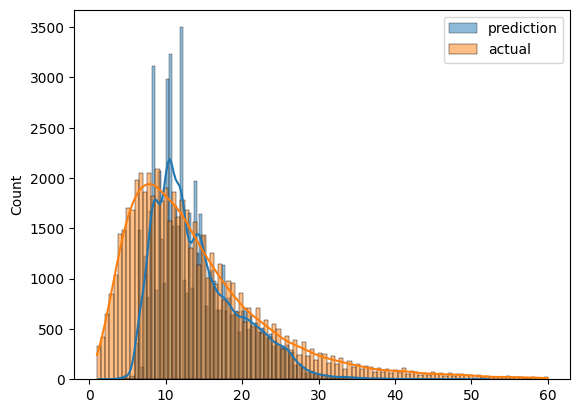

In [25]:
sns.histplot(y_pred, kde=True, label='prediction')
sns.histplot(y_train, kde=True, label='actual')

plt.legend();

## Evaluating the model

In [27]:
def read_dataframe(path):
    df = pd.read_parquet(path)
    df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds() / 60.0
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df

In [29]:
df_val = read_dataframe("./data/green_feb.parquet")

In [30]:
val_dict = df_val[categorical].to_dict(orient='records')

In [31]:
X_val = dv.transform(val_dict)
y_val = df_val.duration.values

In [32]:
y_pred = linear_model.predict(X_val)

In [33]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 8.18459930729865


## mlflow experiments

In [39]:
with mlflow.start_run():
    # Logging information about this run
    mlflow.set_tag("developer", "chih")

    # Which data are we training on?
    mlflow.log_param("train_data_path", "./data/green_jan.parquet")
    mlflow.log_param("test_data_path", "./data/green_feb.parquet")

    # hyperparameters
    alpha = 0.02
    mlflow.log_param("alpha", alpha)

    # train
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)

    # val
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print("RMSE:", rmse)

    # keep track of model preformance
    mlflow.log_metric("rmse", rmse)


RMSE: 8.830209344003055


## Save the model

In [47]:
with open("models/lin_reg.bin", "wb") as f:
    pickle.dump((dv, linear_model), f)